# 用朴素贝叶斯完成语种检测
我们试试用朴素贝叶斯完成一个语种检测的分类器，说起来，用朴素贝叶斯完成这个任务，其实准确度还不错。

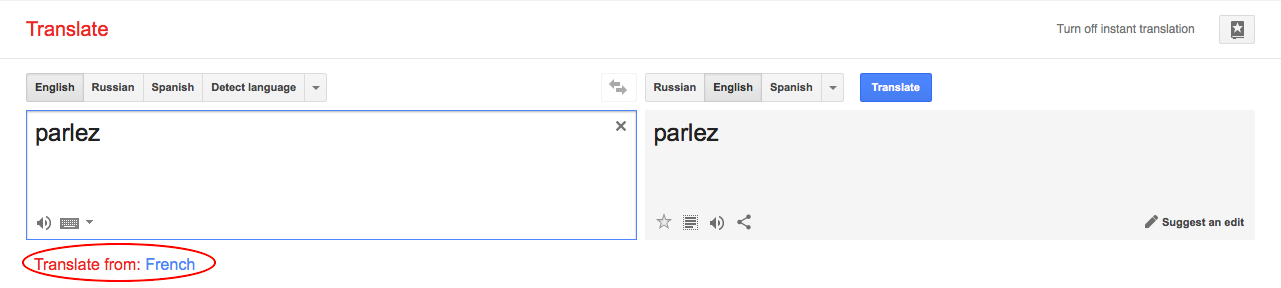

## 查看数据，并划分训练集和验证集

In [1]:
in_f = open('data.csv')
lines = in_f.readlines() # 一次读取整个文件，每行的内容放在一个字符串变量中作为列表的一个元素。
in_f.close()
dataset = [(line.strip()[:-3], line.strip()[-2:]) for line in lines]
# 把句子和语言分开，这里.strip()把\n去掉了。
print(lines[0]) # 打印第一个句子
print(dataset[0])

1 december wereld aids dag voorlichting in zuidafrika over bieten taboes en optimisme,nl

('1 december wereld aids dag voorlichting in zuidafrika over bieten taboes en optimisme', 'nl')


In [2]:
from sklearn.model_selection import train_test_split
x, y = zip(*dataset) # 解压缩
x, y = list(x),list(y) 
print(x[0],y[0])
print("-----"*10)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
# 默认0.25的比例

print(len(x_train),x_train[0],y_train[0])
print(len(x_test),x_test[0],y_test[0])

1 december wereld aids dag voorlichting in zuidafrika over bieten taboes en optimisme nl
--------------------------------------------------
6799 io non ho ipad ma mi sa che 猫 fatta un po meglio sfrutta meglio la superficie it
2267 ook jullie bedankt voor jullie steun nl


## 数据去燥，设置正则化规则

In [3]:
import re
#因为是twitter的数据，有时候会有一些@ # http等字符。
def remove_noise(document):
    noise_pattern = re.compile("|".join(["http\S+", "\@\w+", "\#\w+"]))
    # 关于正则表达式的使用方法，看第一节课
    
    clean_text = re.sub(noise_pattern, "", document)
    # 使用空白""替换document中每一个匹配noise_pattern规则的子串。
    return clean_text.strip()

#举例
remove_noise("Trump images are now more popular than cat gifs. @trump a #trends http://www.trumptrends.html")
# http\S+ 匹配的是http://www.trumptrends.html
# \@\w+ 匹配的是@trump
# \#\w+ 匹配的是#trends

'Trump images are now more popular than cat gifs.  a'

## 统计词频，并选取1000个特征作为输入的特征维度

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# 关于CountVectorizer参数可以看这个：https://blog.csdn.net/weixin_38278334/article/details/82320307

vec = CountVectorizer(
    lowercase=True,     # 将所有字符变成小写
    analyzer='char_wb', # 按ngram_range：1～2个字符划分特征
    ngram_range=(1,2),  # 考虑两个单词的的关联顺序
    max_features=1000,  # 选取出现次数最多的1000个特征
    preprocessor=remove_noise  # 调用前面去燥的函数，这里是说计数前需要先做这一步
)
vec.fit(x_train)
print(vec.transform(x_train).toarray()) # 训练集
print(vec.transform(x_train).toarray().shape) # 训练集维度
vec.get_feature_names()[:50] # 看下选取的1000个特征前100个长啥样，可以看到按1～2个字符不等划分特征。

[[34  0  0 ...  0  0  0]
 [22  0  0 ...  0  0  0]
 [18  0  0 ...  0  0  0]
 ...
 [32  0  0 ...  0  0  0]
 [18  0  0 ...  0  0  0]
 [ 8  0  0 ...  0  0  0]]
(6799, 1000)


[' ',
 ' 0',
 ' 1',
 ' 2',
 ' 3',
 ' 4',
 ' 5',
 ' 6',
 ' 7',
 ' 8',
 ' 9',
 ' a',
 ' b',
 ' c',
 ' d',
 ' e',
 ' f',
 ' g',
 ' h',
 ' i',
 ' j',
 ' k',
 ' l',
 ' m',
 ' n',
 ' o',
 ' p',
 ' q',
 ' r',
 ' s',
 ' t',
 ' u',
 ' v',
 ' w',
 ' x',
 ' y',
 ' z',
 ' 煤',
 ' 猫',
 ' 盲',
 ' 眉',
 ' 茅',
 ' 锚',
 '0',
 '0 ',
 '00',
 '01',
 '02',
 '04',
 '05']

## 训练及预测

In [5]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vec.transform(x_train), y_train)
#classifier.fit(vec.transform(x_train).toarray(), y_train) 也可以
print(classifier.score(vec.transform(x_test), y_test))
# 打印准确率
print(classifier.predict(vec.transform(['This is an English sentence'])))
# 测试下

0.9770621967357741
['en']


## 重新封装下

In [6]:
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


class LanguageDetector():

    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(ngram_range=(1,2), max_features=1000, preprocessor=self._remove_noise)

    def _remove_noise(self, document):
        noise_pattern = re.compile("|".join(["http\S+", "\@\w+", "\#\w+"]))
        clean_text = re.sub(noise_pattern, "", document)
        return clean_text

    def features(self, X):
        return self.vectorizer.transform(X)

    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)

    def predict(self, x):
        return self.classifier.predict(self.features([x]))

    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

In [7]:
in_f = open('data.csv')
lines = in_f.readlines()
in_f.close()
dataset = [(line.strip()[:-3], line.strip()[-2:]) for line in lines]
x, y = zip(*dataset)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

language_detector = LanguageDetector()
language_detector.fit(x_train, y_train)
print(language_detector.predict('This is an English sentence'))
print(language_detector.score(x_test, y_test))

['en']
0.9775033083370093
